# Aperture photometry
In this tutorial is a rudimentary introduction to using the [Photutils](https://photutils.readthedocs.io/en/stable/index.html) to perform aperture photometry.

Before you can use Photutils you will need to download the package. If you are using the Anaconda distribution of Python (recommended) you can install Photutils using the [conda-forge Anaconda channel](https://anaconda.org/conda-forge/photutils), run:
```
conda install -c conda-forge photutils
```
If you are using a different Python distribution, see the [Photoutils Installation page](https://photutils.readthedocs.io/en/stable/install.html).

## Outline
Here's an outline of the procedure we will follow:
 - Read the FITS file and display the image
 - Detect the sources locations and estimated brightness using `DAOStarFinder()`
 - Perform aperture photometry on the selected sources using `aperture_photometry()`

We start by loading some needed packages and set-up the image display.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture
from photutils.aperture import aperture_photometry

plt.style.use('im_disp.mplstyle') 

## Read the FITS file and display the image
Now we read the `stars10_p.fits` file and display the image.

In [2]:
hdu_list = fits.open('images/stars10_p.fits')
hdu_list.info()
imheader = hdu_list[0].header
imdata = hdu_list[0].data
hdu_list.close()

Filename: images/stars10_p.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   (512, 512)   float64   


Below I have used `plt.imshow()` to display the image, but you might find it easier to use [**SAOImageDS9**](https://sites.google.com/cfa.harvard.edu/saoimageds9/home) to find the approximate postion of one of the stars to plot a stellar profile. 

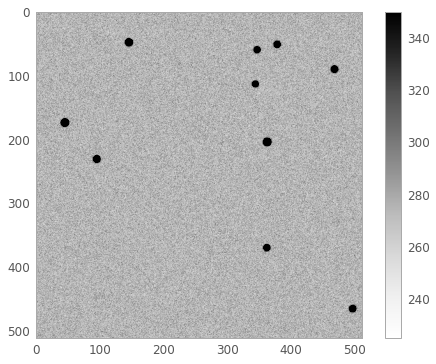

In [3]:
plt.imshow(imdata,cmap='Greys',vmin=225,vmax=350)
plt.colorbar()

## Detect the sources locations and estimated brightness using `DAOStarFinder()`
DAOStarFinder finds stars by looking for objects in the image that have a peak pixel value above a specified threshold and that are shaped like a star. The threshold value is set with the keyword argument `threshold` and is the absolute pixel value above which to select sources. We will set the threshold by subtracting the background level specified by the `sky` keyword argument. We will set the `threshold` equal to five times the standard deviation of the sky background pixel values. If we set the threshold at this level, we make it unlikely for statistical fluctuations in the image to register as a star.

The sizes and shapes of the stellar profiles are assumed to be similar to a 2D Gaussians. The Gaussian width is given by the keyword argument `fwhm` which is the full width at half maximum of the Gaussian. We will assume the stars have a spherical profile, although DAOStarFinder can accommodate elliptical profiles if needed. 

### Determining the value for the `sky` background and  `threshold`
I use `sigma_clipped_stats()` from the `astropy.stats` package to estimate the background level and its standard deviation.

In [4]:
mean, median, std = sigma_clipped_stats(imdata, sigma=3.0)
print(mean, median, std) 

275.0551320003667 275.0 10.164145396458391


We will use `median` for the `sky` background level.

### Determine a value for `fwhm`
I will choose a bright star from the image above to estimate the `fwhm` of the stellar profiles. I chose the bright star at coordinates $x \approx$ 362 and $y \approx$ 205. I slice rows 185 through 226 and column 362 from the image and plot the slice to see the stellar profile. Remember, row values correspond to $y$ positions in the image and columns correspond to $x$ values.

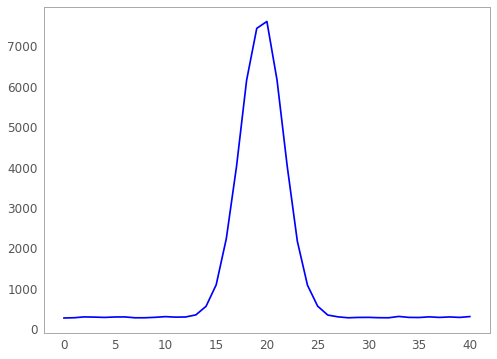

In [5]:
starprofile = imdata[185:226,362:363]
plt.plot(starprofile)

I estimate from the plot that the FWHM of the profile is about 6 pixels. This is also a rough estimated of the seeing.

### Use `DAOStarFinder` to find stars
First line essentially sets parameters for DAOStarFinder, the next command finds the stars from the background subtracted image, and the final command prints out all the found sources and their x and y centroids.

In [6]:
daofind = DAOStarFinder(fwhm=6.0,sky=median,threshold=5.*std)
sources=daofind.find_stars(imdata-median)
sources['id', 'xcentroid','ycentroid'].pprint()

 id     xcentroid          ycentroid     
--- ------------------ ------------------
  1  145.0466740954732   48.5016507203063
  2  377.0507281761218  51.73905591582913
  3 345.67755179734627 60.173228935994196
  4  466.8857536825165  90.53124639723883
  5 342.93794409781896 113.71386649104907
  6  44.69673315390794 174.22874704995158
  7 361.43235753175156 204.49532973915282
  8  94.63674491019371  231.2429129007454
  9  360.9014844180293 370.14910718838206
 10  495.2414605123075  465.4347576764474


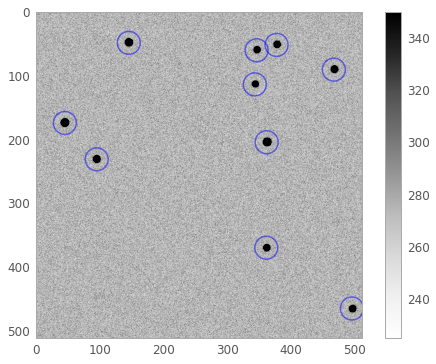

In [8]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
# define apertrues
r_a = 3*6
apertures = CircularAperture(positions, r=r_a)

plt.imshow(imdata,cmap='Greys',vmin=225,vmax=350)
plt.colorbar()
apertures.plot(color='blue', lw=1.5, alpha=0.5)

## Perform aperture photometry on the selected sources using `aperture_photometry()`
